In [3]:
import numpy as np
import pandas as pd
import random

In [4]:
def all_columns(X, rand):
  return range(X.shape[1])


def random_sqrt_columns(X, rand):
  c = np.arange(X.shape[1])
  rand.shuffle(c)
  c = c[:int(np.sqrt(X.shape[1]))]
  return c

In [251]:
def load_tki(filename):
  df = pd.read_csv(filename)
  columns = df.columns
  X_columns = columns[:-1]
  y_column = columns[-1]
  X = df[X_columns].values
  y = df[y_column].values
  classes = np.unique(y)
  legend = {1: classes[0], 0: classes[1]}
  y = (y == classes[0]).astype(int)
  return X, y, legend

def tki():
  X, y, legend = load_tki('tki-resistance.csv')
  first_n = 130
  train = [X[:first_n], y[:first_n]]
  test = [X[first_n:], y[first_n:]]
  return train, test, legend

In [252]:
train, test, legend = tki()

In [253]:
X = train[0]
y = train[1]

In [254]:
random_sqrt_columns(X, random.Random(1))

array([ 19, 102,  33,  18,  32, 176, 190,  12, 161, 144,  23, 169,  79,
        36])

In [12]:
class Tree:
  def __init__(self, rand=None,
         get_candidate_columns=all_columns,
         min_samples=2):
    self.rand = rand  # for replicability
    self.get_candidate_columns = get_candidate_columns  # needed for random forests
    self.min_samples = min_samples
    
  def gini(self, y):
    p = np.bincount(y) / len(y)
    return 1 - np.sum(p**2)
  
  def gain(self, X, y, column, thr, current_gini):
    # gain of a given split
    under_thr = X[:, column] < thr
    y_under = y[under_thr]
    y_over = y[~under_thr]
    new_gini = (len(y_under) * self.gini(y_under) + len(y_over) * self.gini(y_over)) / len(y)

    return current_gini - new_gini

  def build(self, X, y):
    # if there is too few samples or all the same return a leaf with majority class
    if len(y) < self.min_samples or len(y) == 1 or len(np.unique(y)) == 1:
      return TreeNode(np.bincount(y).argmax())
    
    # find the best split
    current_gini = self.gini(y)
    best_gain, best_column, best_thr = 0, 0, 0
    columns = self.get_candidate_columns(X, self.rand)
    for column in columns:
      # go over all possible splits
      sorted_ids = np.argsort(X[:, column])
      for i in range(1, len(X)):
        if X[sorted_ids[i], column] != X[sorted_ids[i-1], column]:
          thr = (X[sorted_ids[i], column] + X[sorted_ids[i-1], column]) / 2
          gain = self.gain(X, y, column, thr, current_gini)
          if gain > best_gain:
            best_gain, best_column, best_thr = gain, column, thr
    
    # if no improvement by splitting return a leaf
    if best_gain == 0:
      return TreeNode(np.bincount(y).argmax())
    
    # build the subtrees using best split
    under_thr = X[:, best_column] < best_thr
    X_under, y_under = X[under_thr], y[under_thr]
    X_over, y_over = X[~under_thr], y[~under_thr]
    left = self.build(X_under, y_under)
    right = self.build(X_over, y_over)

    return TreeNode(None, left, right, best_column, best_thr)



class TreeNode:
  def __init__(self, prediction, left=None, right=None, column=None, thr=None):
    self.prediction = prediction
    self.left = left
    self.right = right
    self.column = column
    self.thr = thr

  def predict(self, X):
    # if it is a leaf return the prediction
    if self.prediction is not None:
      return self.prediction
    
    # otherwise split the data and recursively predict
    under_thr = X[:, self.column] < self.thr
    pred_left = self.left.predict(X[under_thr])
    pred_right = self.right.predict(X[~under_thr])

    # merge predictions
    pred = np.empty(len(X), dtype=int)
    pred[under_thr] = pred_left
    pred[~under_thr] = pred_right

    return pred
  


In [241]:
class RandomForest:
  def __init__(self, rand=None, n=50):
    self.n = n
    self.rand = rand
    self.rftree = Tree(rand=rand,
              get_candidate_columns=random_sqrt_columns,
              min_samples=1)
  
  def build(self, X, y):
    bags = []
    trees = []
    oob = []

    # bootstrap samples
    for i in range(self.n):
      ids = self.rand.choices(range(X.shape[0]), k=len(X))
      bags.append(ids)
      oob_i = [i for i in range(len(X)) if i not in ids]
      oob.append(oob_i)
      X_bag, y_bag = X[ids], y[ids]
      trees.append(self.rftree.build(X_bag, y_bag))
    
    return RFModel(self.n, bags, trees, oob, self.rand, X, y)



class RFModel:
  def __init__(self, n, bags, trees, oob, rand, X, y):
    self.n = n
    self.bags = bags
    self.trees = trees
    self.oob = oob
    self.rand = rand
    self.X = X
    self.y = y

  def predict(self, X):
    pred = np.zeros(len(X), dtype=int)
    for tree in self.trees:
      pred += tree.predict(X)
    
    pred = np.round(pred / self.n)
    return pred

  def importance(self):
    def misscl_rate(y, preds):
      errors = preds != y
      return errors.sum() / len(y)
    
    n_features = self.X.shape[1]
    imps = np.zeros(n_features)
    # go over all features
    for feat in range(n_features):
      # go over all trees
      for i in range(self.n):
        oob_ids = self.oob[i]
        oob_X = self.X[oob_ids, :]
        oob_y = self.y[oob_ids]
        miss_before = misscl_rate(oob_y, self.trees[i].predict(oob_X))

        # permute the feature
        permuted_X = oob_X.copy()
        self.rand.shuffle(permuted_X[:, feat])
        miss_after = misscl_rate(oob_y, self.trees[i].predict(permuted_X))
        diff = miss_after - miss_before
        imps[feat] += diff

    return imps / self.n


In [270]:
t = Tree(rand=random.Random(42),
                                 get_candidate_columns=all_columns,
                                 min_samples=2)
p = t.build(train[0], train[1])

In [305]:
pred = p.predict(test[0])

In [321]:
def evaluate(pred, y):
    errors = pred != y
    missclassification_rate = errors.sum() / len(y)
    standard_error = np.std(errors) / np.sqrt(len(y))
    return missclassification_rate, standard_error

def hw_tree_full(train, test):
    t = Tree(rand=random.Random(42),
        get_candidate_columns=all_columns,
        min_samples=2)
    p = t.build(train[0], train[1])
    eval_train = evaluate(p.predict(train[0]), train[1])
    eval_test = evaluate(p.predict(test[0]), test[1])
    return eval_train, eval_test

def hw_randomforests(train, test):
    rf = RandomForest(rand=random.Random(0),
        n=100)
    p = rf.build(train[0], train[1])
    eval_train = evaluate(p.predict(train[0]), train[1])
    eval_test = evaluate(p.predict(test[0]), test[1])
    return eval_train, eval_test

In [322]:
hw_tree_full(train, test)

((0.0, 0.0), (0.1896551724137931, 0.05147582090425588))

In [323]:
hw_randomforests(train, test)

((0.0, 0.0), (0.017241379310344827, 0.017092100489256894))

In [313]:
evaluate(pred, test[1])

(0.017241379310344827, 0.017092100489256894)

In [361]:

all = [np.concatenate((train[0], test[0])), np.concatenate((train[1], test[1]))]

In [360]:
print('Building RF on all data for importance')
rf = RandomForest(rand=random.Random(1),
                          n=100)
all = [np.concatenate((train[0], test[0])), np.concatenate((train[1], test[1]))]
p = rf.build(train[0], train[1])
print('Calculating importance on all')
imp = p.importance()
print('Saving importance graph')

Building RF on all data for importance


KeyboardInterrupt: 

In [391]:
import matplotlib.pyplot as plt
imp_sort = imp.argsort()
print(imp_sort[::-1][:10])

[ 75  79  37  78 144 181 143  76  35  39]


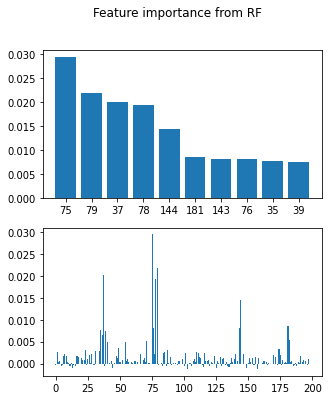

In [394]:
fig, axs = plt.subplots(2, 1, figsize=(5, 6))
fig.suptitle('Feature importance from RF')
axs[0].bar(range(10), imp[imp_sort[::-1]][:10], tick_label=imp_sort[::-1][:10])
axs[1].bar(range(len(imp)), imp)
# plt.show()
plt.savefig('importance.pdf')

In [377]:
rand = random.Random(1)
feats = np.zeros(all[0].shape[1])
sample_size = int(np.sqrt(len(all[1])))*2
# sample_size = len(all[1]) // 2
for i in range(100):
    c = np.arange(len(all[0]))
    rand.shuffle(c)
    c = c[:sample_size]
    data = [all[0][c], all[1][c]]
    t = Tree(rand=rand,
            get_candidate_columns=all_columns,
            min_samples=sample_size)
    p = t.build(data[0], data[1])
    feats[p.column] += 1
    

In [389]:
feats_sort = feats.argsort()
print(feats_sort[::-1][:10])

[ 75  78  71  37  79  39 143  85  84  76]


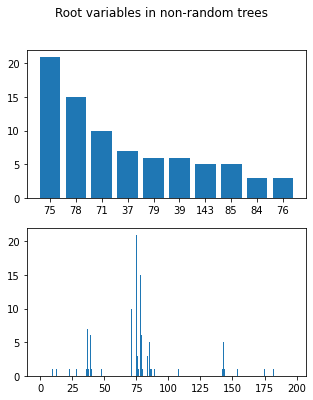

In [395]:
fig, axs = plt.subplots(2, 1, figsize=(5, 6))
fig.suptitle('Root variables in non-random trees')
axs[0].bar(range(10), feats[feats_sort[::-1]][:10], tick_label=feats_sort[::-1][:10])
axs[1].bar(range(len(feats)), feats)
# plt.show()
plt.savefig('roots.pdf')

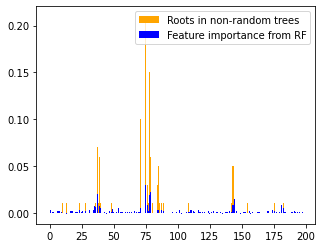

In [420]:
# put both bottom subplots as two sets for the same plot

fig = plt.figure(figsize=(5, 4))
plt.bar(range(len(feats)), feats/100, color='orange', label='Roots in non-random trees')
plt.bar(range(len(imp)), imp, color='blue', label='Feature importance from RF')
plt.legend()
plt.savefig('comparison.pdf')

In [407]:
ns = [1, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]
miscls = []
uncs = []

for n in ns:
    # print(n)
    rf = RandomForest(rand=random.Random(1),
                          n=n)
    p = rf.build(train[0], train[1])
    eval_test = evaluate(p.predict(test[0]), test[1])
    miscls.append(eval_test[0])
    uncs.append(eval_test[1])

1
3
5
10
15
20
25
30
35
40
45
50
60
70
80
90
100


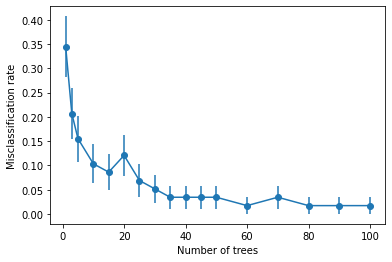

In [408]:
# plot
fig, ax = plt.subplots()
ax.errorbar(ns, miscls, yerr=uncs, fmt='-o')
ax.set_xlabel('Number of trees')
ax.set_ylabel('Misclassification rate')
plt.show()

In [409]:
miscls

[0.3448275862068966,
 0.20689655172413793,
 0.15517241379310345,
 0.10344827586206896,
 0.08620689655172414,
 0.1206896551724138,
 0.06896551724137931,
 0.05172413793103448,
 0.034482758620689655,
 0.034482758620689655,
 0.034482758620689655,
 0.034482758620689655,
 0.017241379310344827,
 0.034482758620689655,
 0.017241379310344827,
 0.017241379310344827,
 0.017241379310344827]